## Resample data into Healpix



1. Create HEALPix grid 
2. Extract data if it is still in a zip file
3. Interpolate from initial points to Healpix grid. Uses linear interpolation
4. Save file

Interpolation possibilities:

1. Interpolate only Temperature, Geopotential and TOA
2. Interpolate all files and save chuncked version
3. Interpolate all files and save without specifying chunks

In [1]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import zipfile
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np
import xesmf as xe

import os
from pathlib import Path
import healpy as hp

In [2]:
# use "nearest neighbors" for datapoints outside the convex hull

In [3]:
input_dir = '../data/equiangular/5.625deg/'
nearest = True

if nearest:
    output_dir = '../data/healpix/5.625deg_nearest/'
else:
    output_dir = '../data/healpix/5.625deg/'
    
#output_dir =  '../data/healpix/5.625deg_chunks/'   
nside = 16
n_pixels = 12*(nside**2)

In [4]:
# New HEALPix grid
n_pixels = 12*(nside**2)
hp_lon, hp_lat = hp.pix2ang(nside, np.arange(n_pixels), lonlat=True, nest=True)
lon_idx = xr.DataArray(hp_lon, dims=["lon"])
lat_idx = xr.DataArray(hp_lat, dims=["lat"])

In [5]:
if nearest and not os.path.isdir(output_dir):
    !mkdir '../data/healpix/5.625deg_chunks/'

In [5]:
all_files = os.listdir(input_dir)
all_files

['toa_incident_solar_radiation',
 'total_precipitation',
 'potential_vorticity',
 'temperature_850',
 'vorticity',
 'geopotential_500',
 'constants',
 'total_cloud_cover',
 'specific_humidity',
 '2m_temperature',
 '.ipynb_checkpoints',
 'temperature',
 'relative_humidity',
 'geopotential']

### Option 1. Only Temperature, Geopotential and TOA. Save with new chunks

Geopotential

In [85]:
ds = xr.open_mfdataset(input_dir + 'geopotential_500' + '/*.nc', combine='by_coords')

In [86]:
interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node', method='nearest')

In [87]:
aux = xr.Dataset({'z': (['time', 'node'], interp_ds.z.data.rechunk((500,-1)))}, \
            coords={'time':interp_ds.time.values, 
                   'node':interp_ds.node.values})

In [88]:
aux = aux.assign_coords(lat = ('node', interp_ds.lat.values), lon=('node', interp_ds.lon.values))

In [90]:
aux.to_netcdf(output_dir + 'geopotential_500' + '/geopotential_500_5.625deg.nc')

Temperature

In [91]:
ds = xr.open_mfdataset(input_dir + 'temperature_850' + '/*.nc', combine='by_coords')

In [92]:
interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node', method='nearest')

In [93]:
aux = xr.Dataset({'t': (['time', 'node'], interp_ds.t.data.rechunk((500,-1)))}, \
            coords={'time':interp_ds.time.values, 
                   'node':interp_ds.node.values})

In [94]:
aux = aux.assign_coords(lat = ('node', interp_ds.lat.values), lon=('node', interp_ds.lon.values))

In [95]:
aux.to_netcdf(output_dir + 'temperature_850' + '/temperature_850_5.625deg.nc')

TOA

In [73]:
ds = xr.open_mfdataset(input_dir + 'toa_incident_solar_radiation' + '/*.nc', combine='by_coords')

In [74]:
interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node', method='nearest')

In [81]:
aux = xr.Dataset({'tisr': (['time', 'node'], interp_ds.tisr.data.rechunk((500,-1)))}, \
            coords={'time':interp_ds.time.values, 
                   'node':interp_ds.node.values})

In [82]:
aux = aux.assign_coords(lat = ('node', interp_ds.lat.values), lon=('node', interp_ds.lon.values))

In [84]:
aux.to_netcdf(output_dir + 'toa_incident_solar_radiation' + '/toa_incident_solar_radiation_5.625deg.nc')

## Option 2.
### Function for interpolation generation, saved chunked file

In [7]:
def save_mf(dir_files):
    ds = xr.open_mfdataset(input_dir + dir_files + '/*.nc', combine='by_coords')
    interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node', method='nearest')
    interp_ds = interp_ds.assign_coords(node=np.arange(n_pixels))
    aux = interp_ds.chunk({'time':720})
    years, datasets = zip(*aux.groupby("time.year"))
    out_path =  output_dir + dir_files + "/"
    out_filename = dir_files + '_5.625deg_'
    
    
    paths = [out_filename + "%s.nc" % y for y in years]
    xr.save_mfdataset(datasets, [out_path + p for p in paths])

In [9]:
for f in all_files:
    print('Processing ', f)
    save_mf(f)

Processing  temperature


## Option 3.

### Function for interpolation generation, NO chunking

In [32]:

for f in all_files:
    print('Working on ', f)
    
    # Check if file has been unzip
    if not os.path.isfile(input_dir + f + '/' + f + '_1979_5.625deg.nc') and not os.path.isfile(input_dir + f + '/' + f + '_5.625deg.nc'):
        print('Data Extraction...')
        # extract data in the same folder 
        with zipfile.ZipFile(input_dir + f + '/' + f + '_5.625deg.zip',"r") as zip_ref:
            zip_ref.extractall(input_dir + f + '/')
            
    # Interpolate
    print('Interpolation...')
    ds = xr.open_mfdataset(input_dir + f + '/*.nc', combine='by_coords')
    
    #linear interpolation
    if nearest:
        interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node', method='nearest') 
    else:
        interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node') 
    interp_ds = interp_ds.assign_coords(node=np.arange(n_pixels))
    
    # Create out folder
    out_path =  output_dir + f + "/"
    Path(out_path).mkdir(parents=True, exist_ok=True)
    
    # Save
    out_filename = f + '_5.625deg.nc'
    interp_ds = interp_ds.chunk({'time':720})
    interp_ds.to_netcdf(out_path + out_filename)

Working on  geopotential_500
Data Extraction...
Interpolation...


Plot of values on the original grid. Dots in red represent the new grid.

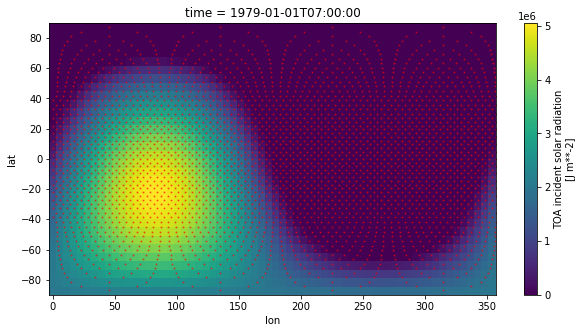

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
ds_aux.tisr.isel(time=0).plot(ax=ax)
ax.plot(lon_idx.values, lat_idx.values, 'o', alpha=0.5, c='red', markersize=1)
plt.show()

Interpolated with xESMF

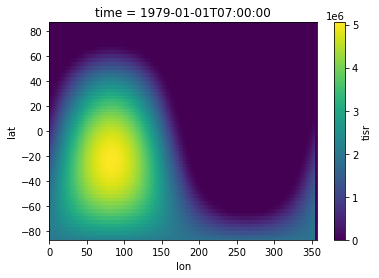

In [19]:
ax = ds_out.tisr.isel(time=0).sortby(['lon','lat']).plot()